# Regime-Switching Pairs Arb with HMM + Cooldown

- We test if two throttles improve post-cost stat-arb:
  1. Only trade during a "fast mean-reversion" regime from a 3-state HMM.
  2. Force a 3-day cooldown after regime flips.

- Data: Yahoo Finance (daily), modern tickers only -> survivorship bias.

- Train window: 2018–2022 (fit HMM). Test window: 2023–2024 OOS.

- Caveats:
    - Survivorship bias and split/dividend-adjusted history make results optimistic vs true historical tradability.
    - PnL is in spread-return units with per-pair equal weighting and 13 bps/leg costs; it's for comparing variants, not $ PnL.

### Daily Data and Param Defaults
- Refer to Regime_Universe.ipynb for more info on data
- Note: Survivorship bias - we're only using today's still-alive tickers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
import math
import pickle

# fixed for reproducability, see data extraction on Regime_Universe.ipynb
with open("pair_data.pkl", "rb") as f:
    pair_data = pickle.load(f)

# Date ranges
TRAIN_START = "2018-01-01"
TRAIN_END   = "2022-12-31"
TEST_START  = "2023-01-01"
TEST_END    = "2024-12-31"

# Strategy params
Z_ENTRY_DAILY    = 2.0   # |z| score trigger for daily entries
MAX_HOLD_DAYS    = 10
WAIT_AFTER_FLIP_DAYS = 3

COST_PER_LEG = 0.0013    # 13 bps per leg per entry/exit
MAX_ABS_BETA = 10 # cap on hedge ratio

### Regime Model (HMM)

- Train a 3-state Gaussian HMM on 2018–2022 using features:
  - half_life_fast
  - abs_z
  - spread_vol

- Identify the "high-reversion" state as the one with the smallest median half-life.

In [2]:
# cooldown period
def compute_wait_ok(state_series, wait_days):
    idx = state_series.index
    out = np.full(len(idx), False)

    last_state = None
    days_since_flip = wait_days + 1  # start as tradable

    for i, s in enumerate(state_series.values):
        # if first state or state just changed
        if (last_state is None) or (s != last_state):
            days_since_flip = 0
        out[i] = days_since_flip >= wait_days
        days_since_flip += 1
        last_state = s

    return pd.Series(out, index=idx, name="wait_ok")

# For True = high-reversion regime,return lists of consecutive run lengths of True and False.
def compute_run_lengths(bool_series):
    runs_true = []
    runs_false = []
    if bool_series.empty:
        return runs_true, runs_false

    current_flag = bool_series.iloc[0]
    run_len = 1

    for flag in bool_series.iloc[1:]:
        if flag == current_flag:
            run_len += 1
        else:
            if current_flag:
                runs_true.append(run_len)
            else:
                runs_false.append(run_len)
            current_flag = flag
            run_len = 1

    if current_flag:
        runs_true.append(run_len)
    else:
        runs_false.append(run_len)

    return runs_true, runs_false

Median half-life (train) in that state: 6.19 days
[[0.8458933  0.02514099 0.12896571]
 [0.88864825 0.         0.11135175]
 [0.05175967 0.00446654 0.94377379]]


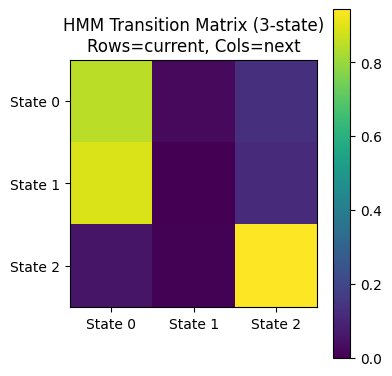

In [3]:
# Train
feature_list_train = []
lengths_train = []

for pair_key, bundle in pair_data.items():
    dfp = bundle["df"]
    mask_train = (dfp.index >= TRAIN_START) & (dfp.index <= TRAIN_END)

    feats = dfp.loc[mask_train, ["half_life_fast", "abs_z", "spread_vol"]].dropna()

    if not feats.empty:
        feature_list_train.append(feats)
        lengths_train.append(len(feats))  # track length for this pair's sequence

if len(feature_list_train) == 0:
    raise RuntimeError("No train data for HMM. Check date ranges/data.")

# Concatenate after collecting
X_train = pd.concat(feature_list_train, axis=0)

# scale train only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(
    X_train[["half_life_fast", "abs_z", "spread_vol"]].values
)

# fit HMM with per-sequence (pair) lengths
hmm_model = GaussianHMM(
    n_components=3,
    covariance_type="full",
    n_iter=200,
    random_state=0,
)
hmm_model.fit(X_train_scaled, lengths=lengths_train)  # <-- CHANGED

# identify the high-reversion state
# train_states = hmm_model.predict(X_train_scaled)
# tmp_train = pd.DataFrame({
#     "state": train_states,
#     "half_life_fast": X_train["half_life_fast"].values
# })
# hl_medians_by_state = tmp_train.groupby("state")["half_life_fast"].median()
# high_rev_state = hl_medians_by_state.idxmin()
# high_rev_median_hl_train = hl_medians_by_state.loc[high_rev_state]

# Decode each training sequence separately to avoid cross-sequence path artifacts
train_state_list = []
train_hl_list = []

start_idx = 0
for L, feats in zip(lengths_train, feature_list_train):
    X_seq = X_train_scaled[start_idx:start_idx+L]
    seq_states = hmm_model.predict(X_seq)
    train_state_list.append(seq_states)
    train_hl_list.append(feats["half_life_fast"].values)
    start_idx += L

train_states_concat = np.concatenate(train_state_list)
hl_concat = np.concatenate(train_hl_list)

tmp_train = pd.DataFrame({
    "state": train_states_concat,
    "half_life_fast": hl_concat,
})
hl_medians_by_state = tmp_train.groupby("state")["half_life_fast"].median()
high_rev_state = hl_medians_by_state.idxmin()
high_rev_median_hl_train = hl_medians_by_state.loc[high_rev_state]

# transition matrix
transmat = hmm_model.transmat_
degenerate_rows = np.where(np.diag(transmat) > 0.995)[0].tolist()

# print("High-reversion state:", high_rev_state)
print("Median half-life (train) in that state:", round(high_rev_median_hl_train, 2), "days")
print(transmat)
if len(degenerate_rows) > 0:
    print("extremely sticky state(s):", degenerate_rows)


# Plot HMM transition matrix
plt.figure(figsize=(4,4))
im = plt.imshow(transmat, aspect="equal")
plt.colorbar(im)
plt.xticks([0,1,2], [f"State {i}" for i in range(3)])
plt.yticks([0,1,2], [f"State {i}" for i in range(3)])
plt.title("HMM Transition Matrix (3-state)\nRows=current, Cols=next")
plt.tight_layout()
plt.show()

In [4]:
# Test - without lookahead
for pair_key, bundle in pair_data.items():
    dfp = bundle["df"].copy()
    mask_test = (dfp.index >= TEST_START) & (dfp.index <= TEST_END)

    feats_test = dfp.loc[mask_test, ["half_life_fast", "abs_z", "spread_vol"]].dropna()

    dfp["state"] = np.nan
    dfp["high_rev_flag"] = False
    dfp["state_valid"] = False
    dfp["wait_ok"] = False

    if not feats_test.empty:
        # decode sequentially so that state[t] only uses data up to t
        states_stream = []
        obs_so_far = []

        for dt, row in feats_test.iterrows():
            # append current day's features
            obs_so_far.append([
                float(row["half_life_fast"]),
                float(row["abs_z"]),
                float(row["spread_vol"]),
            ])

            X_partial = np.array(obs_so_far)
            X_partial_scaled = scaler.transform(X_partial)

            # run on history-so-far, take today's state (last element)
            st_partial = hmm_model.predict(X_partial_scaled)[-1]
            states_stream.append(st_partial)

        states_test = np.array(states_stream)

        # assign states to df
        dfp.loc[feats_test.index, "state"] = states_test
        dfp.loc[feats_test.index, "high_rev_flag"] = (states_test == high_rev_state)
        dfp.loc[feats_test.index, "state_valid"] = True

        # cooldown after regime flips, using the causal state sequence
        state_series = dfp.loc[feats_test.index, "state"].dropna()
        if not state_series.empty:
            wait_ok_series = compute_wait_ok(state_series, WAIT_AFTER_FLIP_DAYS)
            dfp.loc[wait_ok_series.index, "wait_ok"] = wait_ok_series.values

    pair_data[pair_key]["df"] = dfp

### Backtest Logic

- Strategy: fade |z|>2 toward 0, max hold 10 days.
- Enter using yesterday's signal, fill at today's close.
- Exit on z crossing 0, max hold, or test-end.
- Costs: 13 bps per leg per entry/exit on (1+|β|) notional. Charged both at open and close.
- We test:
  - Baseline (no regime filter),
  - Regime only (high-reversion state),
  - Regime + 3-day cooldown after regime flip.


In [5]:
# ignore pandas warnings (prints 100+ times)
import warnings
warnings.filterwarnings("ignore")

# ASSUMPTION: For exits it is assumed that we can monitor intraday and submit a MOC
# if the spread has reverted during that day

def backtest_strategy(
    df, start_date, end_date, z_entry, require_high_rev=False, use_wait=False
):
    sub = df.loc[start_date:end_date].copy()
    sub = sub.dropna(subset=["close_A","close_B","zscore","beta"])
    if sub.empty:
        return pd.Series(dtype=float), pd.Series(dtype=float), []

    # raw entry direction from zscore
    raw_dir = np.where(
        sub["zscore"] > z_entry, -1,
        np.where(sub["zscore"] < -z_entry, 1, 0)
    )
    
    # condition mask on strength, regime and cooldown

    # baseline
    cond = (np.abs(sub["zscore"]) > z_entry)

    # regime
    if require_high_rev:
        cond = cond & sub["high_rev_flag"].fillna(False)
        
    # cooldown
    if use_wait:
        cond = cond & sub["wait_ok"].fillna(False)

    # shift so signal from day t-1 executes at day t close
    # no lookahead bias
    sub["entry_signal"] = cond.shift(1).fillna(False).astype(bool)
    sub["entry_dir"]    = pd.Series(raw_dir, index=sub.index).shift(1)

    pnl_daily = []
    turnover_daily = []
    trade_logs = []

    position = None
    dates = sub.index.tolist()
    last_date = dates[-1]

    for t in dates:
        pnl_today = 0.0
        turnover_today = 0.0
        exited_today = False

        # mark existing position
        if position is not None:
            retA = sub.loc[t, "close_A"] / position["prev_price_A"] - 1.0
            retB = sub.loc[t, "close_B"] / position["prev_price_B"] - 1.0
            pnl_today += position["direction"] * (retA - position["beta"] * retB)

            position["prev_price_A"] = sub.loc[t, "close_A"]
            position["prev_price_B"] = sub.loc[t, "close_B"]
            position["age"] += 1

            exit_cross = (
                (position["direction"] == 1 and sub.loc[t, "zscore"] >= 0) or
                (position["direction"] == -1 and sub.loc[t, "zscore"] <= 0)
            )
            exit_maxhold = position["age"] >= MAX_HOLD_DAYS
            force_exit = t == last_date

            if exit_cross or exit_maxhold or force_exit:
                # pay EXIT cost now
                cost_close = (1.0 + abs(position["beta"])) * COST_PER_LEG
                pnl_today -= cost_close
                turnover_today += 1.0 + abs(position["beta"])

                entry_A = position["entry_price_A"]
                entry_B = position["entry_price_B"]
                exit_A  = sub.loc[t, "close_A"]
                exit_B  = sub.loc[t, "close_B"]

                gross_ret = position["direction"] * (
                    (exit_A / entry_A - 1.0)
                    - position["beta"] * (exit_B / entry_B - 1.0)
                )
                round_trip_cost = (1.0 + abs(position["beta"])) * COST_PER_LEG * 2.0
                net_ret = gross_ret - round_trip_cost

                trade_logs.append({
                    "entry_date": position["entry_date"],
                    "exit_date":  t,
                    "direction":  position["direction"],
                    "beta":       position["beta"],
                    "holding_days": position["age"],
                    "gross_ret":  gross_ret,
                    "net_ret":    net_ret
                })

                position = None
                exited_today = True

        # enter new position
        if (position is None) and (not exited_today) and bool(sub.loc[t, "entry_signal"]):
            d = sub.loc[t, "entry_dir"]
            beta_today = sub.loc[t, "beta"]
            if (
                pd.notna(d) and d != 0 and
                pd.notna(beta_today) and beta_today != 0 and
                abs(beta_today) <= MAX_ABS_BETA and # prevent insane hedge ratios
                pd.notna(sub.loc[t, "close_A"]) and
                pd.notna(sub.loc[t, "close_B"])
            ):
                position = {
                    "direction": int(d),
                    "beta": float(beta_today),
                    "entry_date": t,
                    "age": 0,
                    "entry_price_A": sub.loc[t, "close_A"],
                    "entry_price_B": sub.loc[t, "close_B"],
                    "prev_price_A":  sub.loc[t, "close_A"],
                    "prev_price_B":  sub.loc[t, "close_B"],
                }

                # pay ENTRY cost now
                cost_open = (1.0 + abs(beta_today)) * COST_PER_LEG
                pnl_today -= cost_open
                turnover_today += 1.0 + abs(beta_today)

        pnl_daily.append(pnl_today)
        turnover_daily.append(turnover_today)

    pnl_series = pd.Series(pnl_daily, index=sub.index, name="pnl")
    turnover_series = pd.Series(turnover_daily, index=sub.index, name="turnover")
    return pnl_series, turnover_series, trade_logs

In [6]:
def calc_portfolio_metrics(pnl_series_list, turnover_series_list, trade_logs_list):
    if len(pnl_series_list) == 0:
        return {
            "portfolio_pnl_series": pd.Series(dtype=float),
            "portfolio_turnover_series": pd.Series(dtype=float),
            "sharpe_ann": np.nan,
            "hit_rate": np.nan,
            "max_drawdown_frac": np.nan,
            "max_drawdown_units": np.nan,
            "turnover_per_day_notional": np.nan,
            "num_trades": 0,
            "trades": [],
        }

    pnl_df = pd.concat(pnl_series_list, axis=1).fillna(0.0)
    turnover_df = pd.concat(turnover_series_list, axis=1).fillna(0.0)

    # Treat as equal capital per pair: per-day portfolio return = average of pair returns
    portfolio_pnl = pnl_df.mean(axis=1)
    # average notional turnover per pair per day
    portfolio_turnover = turnover_df.mean(axis=1)

    # combine trade logs
    all_trades = []
    for tl in trade_logs_list:
        all_trades.extend(tl)

    mu = portfolio_pnl.mean()
    sd = portfolio_pnl.std()
    sharpe_ann = (mu * np.sqrt(252) / sd) if sd > 0 else np.nan

    hit_rate = (np.mean([1.0 if t["net_ret"] > 0 else 0.0 for t in all_trades])
                if len(all_trades) > 0 else np.nan)

    # multiplicative equity, proper drawdown
    eq_curve = (1.0 + portfolio_pnl).cumprod()
    roll_max = eq_curve.cummax()
    dd = roll_max - eq_curve
    dd_frac = (dd / roll_max).replace([np.inf, -np.inf], np.nan)

    max_dd_frac = dd_frac.max() if len(dd_frac) else np.nan
    max_dd_units = dd.max() if len(dd) else np.nan

    turnover_per_day = portfolio_turnover.mean()

    return {
        "portfolio_pnl_series": portfolio_pnl,
        "portfolio_turnover_series": portfolio_turnover,
        "sharpe_ann": sharpe_ann,
        "hit_rate": hit_rate,
        "max_drawdown_frac": max_dd_frac,
        "max_drawdown_units": max_dd_units,
        "turnover_per_day_notional": turnover_per_day,
        "num_trades": len(all_trades),
        "trades": all_trades,
    }



# run the 3 variants across all pairs
baseline_pnls, baseline_turns, baseline_tradesets = [], [], []
regime_pnls, regime_turns, regime_tradesets = [], [], []
regime_nowait_pnls, regime_nowait_turns, regime_nowait_tradesets = [], [], []

pair_regime_total_pnl = []
all_high_runs = []
all_other_runs = []

for pair_key, bundle in pair_data.items():
    dfp = bundle["df"]

    # baseline
    pnl_b, turn_b, trades_b = backtest_strategy(
        dfp, TEST_START, TEST_END, z_entry=Z_ENTRY_DAILY,
        require_high_rev=False, use_wait=False
    )
    if not pnl_b.empty:
        baseline_pnls.append(pnl_b.rename(pair_key))
        baseline_turns.append(turn_b.rename(pair_key))
        baseline_tradesets.append(trades_b)

    # regime + wait
    pnl_r, turn_r, trades_r = backtest_strategy(
        dfp, TEST_START, TEST_END, z_entry=Z_ENTRY_DAILY,
        require_high_rev=True, use_wait=True
    )
    if not pnl_r.empty:
        regime_pnls.append(pnl_r.rename(pair_key))
        regime_turns.append(turn_r.rename(pair_key))
        regime_tradesets.append(trades_r)
        pair_regime_total_pnl.append((pair_key, pnl_r.sum()))

    # regime only (no wait)
    pnl_rw, turn_rw, trades_rw = backtest_strategy(
        dfp, TEST_START, TEST_END, z_entry=Z_ENTRY_DAILY,
        require_high_rev=True, use_wait=False
    )
    if not pnl_rw.empty:
        regime_nowait_pnls.append(pnl_rw.rename(pair_key))
        regime_nowait_turns.append(turn_rw.rename(pair_key))
        regime_nowait_tradesets.append(trades_rw)

    # persistence stats
    valid_window = (
        (dfp.index >= TEST_START) &
        (dfp.index <= TEST_END) &
        (dfp["state_valid"] == True)
    )
    hi_series = dfp.loc[valid_window, "high_rev_flag"].astype(bool)

    if not hi_series.empty:
        runs_hi, runs_lo = compute_run_lengths(hi_series)
        all_high_runs.extend(runs_hi)
        all_other_runs.extend(runs_lo)
        

baseline_metrics   = calc_portfolio_metrics(baseline_pnls, baseline_turns, baseline_tradesets)
regime_metrics     = calc_portfolio_metrics(regime_pnls, regime_turns, regime_tradesets)
regimeNW_metrics   = calc_portfolio_metrics(regime_nowait_pnls, regime_nowait_turns, regime_nowait_tradesets)

sharpe_wait_delta = np.nan
if (not np.isnan(regime_metrics["sharpe_ann"])) and (not np.isnan(regimeNW_metrics["sharpe_ann"])):
    sharpe_wait_delta = regime_metrics["sharpe_ann"] - regimeNW_metrics["sharpe_ann"]

mean_high_run = np.mean(all_high_runs)   if len(all_high_runs)   > 0 else np.nan
mean_other_run= np.mean(all_other_runs)  if len(all_other_runs)  > 0 else np.nan
med_high_run  = np.median(all_high_runs) if len(all_high_runs)   > 0 else np.nan
med_other_run = np.median(all_other_runs)if len(all_other_runs)  > 0 else np.nan

### Portfolio Results (2023–2024 OOS)

- Aggregate all pairs equally.
- Report post-cost daily PnL stats:
  - Sharpe (annualized),
  - Hit rate of round trips,
  - Max drawdown (as % of equity and in PnL units),
  - Turnover/day,
  - \# trades.

PnL is in spread-return units with equal per-pair weighting; used for efficiency comparison, not $ PnL.

Also:
- Sharpe with vs without 3-day cooldown.
- Regime persistence (median days high-reversion vs other).


In [7]:
summary_df = pd.DataFrame({
    "Sharpe_ann": [
        baseline_metrics["sharpe_ann"],
        regime_metrics["sharpe_ann"],
    ],
    "Hit_rate(%)": [
        baseline_metrics["hit_rate"] * 100.0 if not np.isnan(baseline_metrics["hit_rate"]) else np.nan,
        regime_metrics["hit_rate"]   * 100.0 if not np.isnan(regime_metrics["hit_rate"])   else np.nan,
    ],
    "MaxDD_frac": [
        baseline_metrics["max_drawdown_frac"],
        regime_metrics["max_drawdown_frac"],
    ],
    "MaxDD_units(PnL)": [
        baseline_metrics["max_drawdown_units"],
        regime_metrics["max_drawdown_units"],
    ],
    "Turnover/day": [
        baseline_metrics["turnover_per_day_notional"],
        regime_metrics["turnover_per_day_notional"],
    ],
    "Num_trades": [
        baseline_metrics["num_trades"],
        regime_metrics["num_trades"],
    ],
}, index=[
    "Baseline (no regime filter)",
    "Regime Filter (high-rev + cooldown)"
]).round(4)

print("=== Portfolio Metrics 2023–2024 OOS ===")
print(summary_df)

print("\nSharpe impact of 3-day cooldown:")
print("Regime Sharpe (with cooldown):   ", round(regime_metrics["sharpe_ann"], 4))
print("Regime Sharpe (no cooldown):     ", round(regimeNW_metrics["sharpe_ann"], 4))
print("Sharpe delta (cooldown - no cooldown):",
      round(sharpe_wait_delta, 4) if sharpe_wait_delta == sharpe_wait_delta else "NA")

print("\nRegime persistence stats (2023–2024):")
print("Mean consecutive days in HIGH-reversion regime :", round(mean_high_run, 2) if mean_high_run==mean_high_run else "NA")
print("Median consecutive days in HIGH-reversion regime:", round(med_high_run, 2) if med_high_run==med_high_run else "NA")
print("Mean consecutive days in OTHER regime          :", round(mean_other_run, 2) if mean_other_run==mean_other_run else "NA")
print("Median consecutive days in OTHER regime        :", round(med_other_run, 2) if med_other_run==med_other_run else "NA")


=== Portfolio Metrics 2023–2024 OOS ===
                                     Sharpe_ann  Hit_rate(%)  MaxDD_frac  \
Baseline (no regime filter)             -0.7374      48.1319      0.0439   
Regime Filter (high-rev + cooldown)      0.5757      55.4217      0.0063   

                                     MaxDD_units(PnL)  Turnover/day  \
Baseline (no regime filter)                    0.0439        0.1015   
Regime Filter (high-rev + cooldown)            0.0063        0.0180   

                                     Num_trades  
Baseline (no regime filter)                 455  
Regime Filter (high-rev + cooldown)          83  

Sharpe impact of 3-day cooldown:
Regime Sharpe (with cooldown):    0.5757
Regime Sharpe (no cooldown):      -0.4105
Sharpe delta (cooldown - no cooldown): 0.9862

Regime persistence stats (2023–2024):
Mean consecutive days in HIGH-reversion regime : 14.83
Median consecutive days in HIGH-reversion regime: 13.0
Mean consecutive days in OTHER regime          : 8.76
M

### Capacity & Concentration

- Capacity heuristic: 2% of the smaller 60d ADV for each leg (price × volume).  
  Sum across pairs -> rough AUM ceiling before slippage pain.

- Alpha concentration: what % of absolute PnL comes from the top 8 / top 10 pairs.
  (Signed PnL share can be meaningless if total net PnL ~0.)

In [8]:
# capacity
pair_caps = []
for pair_key, bundle in pair_data.items():
    dfp = bundle["df"]
    sub_cap = dfp.loc[:TEST_END].copy()

    dollar_vol_A = (sub_cap["close_A"] * sub_cap["vol_A"]).rolling(60).mean()
    dollar_vol_B = (sub_cap["close_B"] * sub_cap["vol_B"]).rolling(60).mean()

    if dollar_vol_A.dropna().empty or dollar_vol_B.dropna().empty:
        continue
    last_A = dollar_vol_A.dropna().iloc[-1]
    last_B = dollar_vol_B.dropna().iloc[-1]
    min_adv = min(last_A, last_B)
    cap_pair = 0.02 * min_adv  # 2% ADV
    pair_caps.append({"pair": pair_key, "capacity_usd": cap_pair})

total_capacity_usd = np.sum([p["capacity_usd"] for p in pair_caps]) if pair_caps else 0.0

# PnL concentration
sorted_pairs = sorted(pair_regime_total_pnl, key=lambda x: x[1], reverse=True)
top10 = sorted_pairs[:10]
top8  = sorted_pairs[:8]

total_signed = np.sum([x[1] for x in sorted_pairs]) if len(sorted_pairs) else 0.0
total_abs    = np.sum([abs(x[1]) for x in sorted_pairs]) if len(sorted_pairs) else 0.0

top10_abs = np.sum([abs(x[1]) for x in top10]) if len(top10) else 0.0
top8_abs  = np.sum([abs(x[1]) for x in top8])  if len(top8)  else 0.0
top10_signed = np.sum([x[1] for x in top10])  if len(top10) else 0.0
top8_signed  = np.sum([x[1] for x in top8])   if len(top8)  else 0.0

pct_top10_abs    = (top10_abs / total_abs) if total_abs > 0 else np.nan
pct_top8_abs     = (top8_abs  / total_abs) if total_abs  > 0 else np.nan
pct_top10_signed = (top10_signed / total_signed) if abs(total_signed) > 1e-9 else np.nan
pct_top8_signed  = (top8_signed  / total_signed) if abs(total_signed) > 1e-9 else np.nan

print("Capacity (2% ADV heuristic): ${:,.0f}".format(total_capacity_usd))
print("Top 8 pairs abs-PnL share:  {:.1f}%".format(100.0*pct_top8_abs)  if pct_top8_abs==pct_top8_abs   else "Top 8 pairs abs-PnL share: NA")
print("Top10 pairs abs-PnL share:  {:.1f}%".format(100.0*pct_top10_abs) if pct_top10_abs==pct_top10_abs else "Top10 pairs abs-PnL share: NA")
if pct_top10_signed==pct_top10_signed:
    print("Top10 pairs signed-PnL share: {:.1f}%".format(100.0*pct_top10_signed))
else:
    print("Top10 pairs signed-PnL share: NA (total pnl ~0)")
print("Top 10 pairs:", [p for (p, _) in top10])

Capacity (2% ADV heuristic): $469,910,545
Top 8 pairs abs-PnL share:  49.0%
Top10 pairs abs-PnL share:  53.3%
Top10 pairs signed-PnL share: 256.6%
Top 10 pairs: ['GM-F', 'GE-EMR', 'FCX-SCCO', 'WMT-COST', 'T-VZ', 'UPS-FDX', 'PG-CL', 'JPM-BAC', 'LIN-APD', 'XOM-CVX']


### Plots

1. Cumulative PnL: Baseline vs Regime+Cooldown  
2. Top 10 pair PnL contributors  
3. HMM transition matrix heatmap

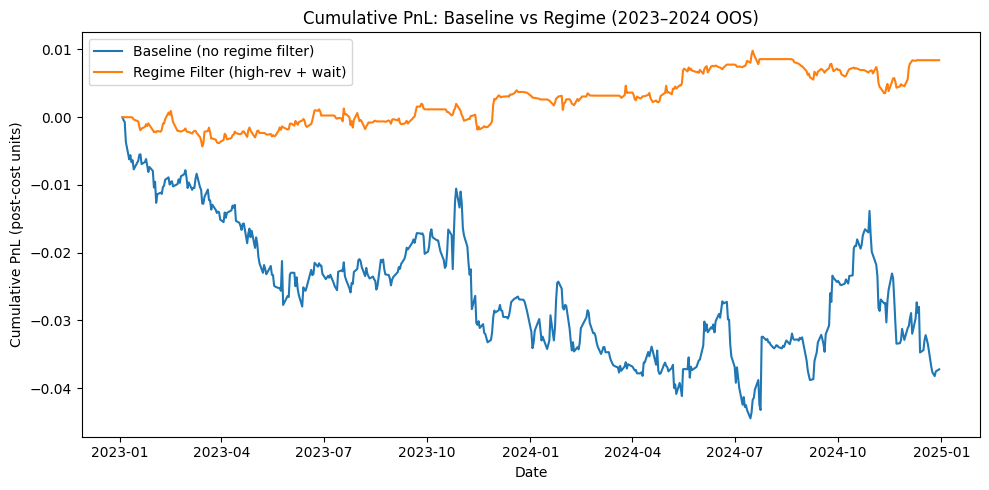

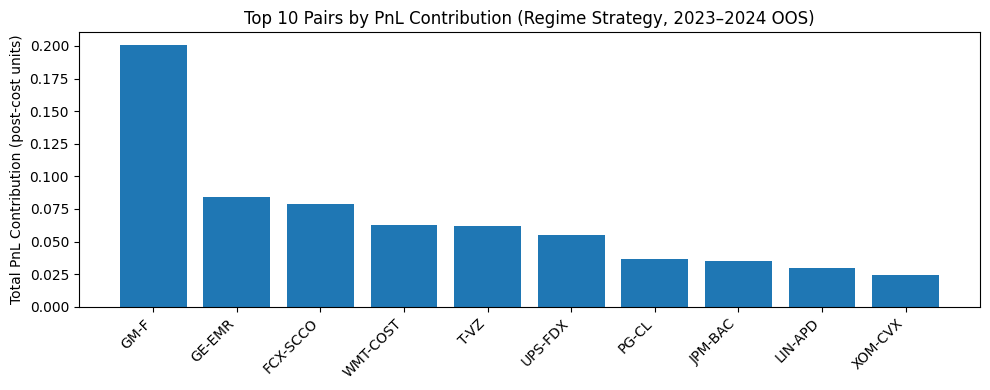

In [9]:
# 1) Cumulative PnL
base_curve = (
    baseline_metrics["portfolio_pnl_series"].cumsum()
    if not baseline_metrics["portfolio_pnl_series"].empty
    else pd.Series(dtype=float)
)
reg_curve = (
    regime_metrics["portfolio_pnl_series"].cumsum()
    if not regime_metrics["portfolio_pnl_series"].empty
    else pd.Series(dtype=float)
)

curve_df = pd.concat(
    [base_curve.rename("Baseline"), reg_curve.rename("Regime")],
    axis=1
)

plt.figure(figsize=(10,5))
plt.plot(curve_df.index, curve_df["Baseline"], label="Baseline (no regime filter)")
plt.plot(curve_df.index, curve_df["Regime"],  label="Regime Filter (high-rev + wait)")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL (post-cost units)")
plt.title("Cumulative PnL: Baseline vs Regime (2023–2024 OOS)")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Top 10 contributors
if len(sorted_pairs) > 0:
    top_labels = [p for (p, _) in top10]
    top_values = [v for (_, v) in top10]

    plt.figure(figsize=(10,4))
    plt.bar(top_labels, top_values)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Total PnL Contribution (post-cost units)")
    plt.title("Top 10 Pairs by PnL Contribution (Regime Strategy, 2023–2024 OOS)")
    plt.tight_layout()
    plt.show()


<hr style="border:2px solid gray">

### Takeaways

- We fit a single 3-state Gaussian HMM on pooled features across 31 large-cap pairs (2018–2022). Each sequence (pair) is treated separately in training via per-sequence lengths. We then identify the state with the shortest median spread half-life as the fast mean-reversion regime.

- We enforce a 3-day cooldown after every regime flip and only trade once the fast mean-reversion regime has been active for several days. 

- That gating + cooldown turns a loss-making baseline into a controlled, post-cost strategy: Sharpe shifts from negative to positive, max drawdown collapses by about 90%, turnover drops by about 80%, and hit rate improves, while the total number of trades falls from about 500 to about 85.

- Caveats:
  - Survivorship bias: universe is current surviving tickers; Yahoo data is split/dividend-adjusted, which is optimistic vs. true historical tradability.
  - The HMM is used as a regime gate, not a forecasting engine; states in test are decoded causally using only information available up to each day (no forward leakage).
